## More than Meets the Ear: The Data and Elements Behind Spotify Songs
Since its humble beginnings in Sweden, **Spotify** has continually grown exponentially to become one of, if not, the world's biggest music streaming provider. Boasting an immense catalog of tracks from around the world, the music giant has gathered mounds of valuable data, both basic and complex, behind the songs deployed in its massive database. For this Notebook, the researchers **Anjelo Antioquia**, **Gabriel Minamedez**, and **Julian Sunpayco** will report their findings in this case study centered around two (2) datasets gathered from online data science community Kaggle related to the songs in Spotify.

This is in partial fulfillment of the course **Statistical Modelling and Simulation (CSMODEL)**.

## Import
Import Python modules**numpy**, **pandas**, and **matplotlib**, and the **`tools.py`** script for custom functions and/or classes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tools

## Dataset #1: The Main Spotify Dataset
The [Spotify dataset](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data.csv) (titled **`data.csv`**) consists of 160,000+ tracks from 1921-2020 found in Spotify as of June 2020. Collected by Kaggle user and Turkish Data Scientist Yamaç Eren Ay, the data was retrieved and tabulated from the **Spotify Web API**. Each row in the dataset corresponds to a track, with variables such as the title, artist, and year located in their respective columns. Aside from the fundamental variables, musical elements of each track, such as the tempo, danceability, and key, were likewise extracted; the algorithm for these values were generated by Spotify based on a range of technical parameters.

Let's bring in that dataset now:

In [2]:
main_df = pd.read_csv("./data.csv")
main_df.head()

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],158648,1928,1928,0.995,0.708,0.1950,0.563,0.1510,-12.428,0.0506,118.469,0.7790,1,10,0,0
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",282133,1928,1928,0.994,0.379,0.0135,0.901,0.0763,-28.454,0.0462,83.972,0.0767,1,8,0,0
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],104300,1928,1928,0.604,0.749,0.2200,0.000,0.1190,-19.924,0.9290,107.177,0.8800,0,5,0,0
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],180760,9/25/28,1928,0.995,0.781,0.1300,0.887,0.1110,-14.734,0.0926,108.003,0.7200,0,1,0,0
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",687733,1928,1928,0.990,0.210,0.2040,0.908,0.0980,-16.829,0.0424,62.149,0.0693,1,11,1,0


With a huge array of variables present as seen above, it may seem overwhelming, but don't be! Together, these variables describe a track in each row, giving each some interesting numerical context across different parameters. Below is the list of variables and their descriptions:
- **`id`**: A unique identifier for each track.
- **`name`**: The track's title.
- **`artists`**: Artist/s who participated in the track.
- **`duration_ms`**: Length of the track in milliseconds (ms).
- **`release_date`**: The track's release date in MM/DD/YYYY, or at the minimum, YYYY.
- **`year`**: The year in which the track was released.
- **`acousticness`***: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- **`danceability`***: Describes how suitable a track is for dancing. A value of 0.0 is least danceable and 1.0 is most danceable.
- **`energy`***: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast and loud.
- **`instrumentalness`***: Predicts whether a track contains no vocals.
- **`liveness`***: Detects the presence of an audience in the recording.
- **`loudness`***: The overall loudness of a track in decibels (dB).
- **`speechiness`***: Detects the presence of spoken words in a track.
- **`tempo`***: The overall estimated tempo of a track in beats per minute (BPM).
- **`valence`***: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.
- **`mode`**: Melodic content from the modality of a track. 1 = Major; 0 = Minor.
- **`key`**: The estimated overall key of a track from the [Pitch Class notation](https://en.wikipedia.org/wiki/Pitch_class). E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- **`popularity`**: A track's popularity, 0-100 where 100 is the most popular based on [Spotify's algorithm](https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/).
- **`explicit`**: Whether or not the track has explicit lyrics. 1 = True; 0 = False.

*Based on the [audio features of a track from Spotify's Web API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

Let's now check the specific information for the variables of this dataset and see if cleaning is needed:

In [3]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                169909 non-null  object 
 1   name              169909 non-null  object 
 2   artists           169909 non-null  object 
 3   duration_ms       169909 non-null  int64  
 4   release_date      169909 non-null  object 
 5   year              169909 non-null  int64  
 6   acousticness      169909 non-null  float64
 7   danceability      169909 non-null  float64
 8   energy            169909 non-null  float64
 9   instrumentalness  169909 non-null  float64
 10  liveness          169909 non-null  float64
 11  loudness          169909 non-null  float64
 12  speechiness       169909 non-null  float64
 13  tempo             169909 non-null  float64
 14  valence           169909 non-null  float64
 15  mode              169909 non-null  int64  
 16  key               16

With 169,909 tracks in total and every variable filled, it's looking good so far! However, let's dig in some more just in case there are anomalies with the data themselves. Let's use the `pd.Series.unique()` function to check the variables with limited choices of possible values (rules indicated in comments for each print statement):

In [4]:
print(main_df["mode"].unique()) # Should be either 0 or 1
print(main_df["key"].unique()) # Should be values from 0 to 11, or -1
print(main_df["explicit"].unique()) # Should be either 0 or 1

[1 0]
[10  8  5  1 11  6  9  7  4  2  3  0]
[0 1]


It looks like the variables `mode`, `key`, and `explicit` are good to go. Let's now check the variables supposedly bound within a given range:

In [5]:
print(str(main_df["year"].min()) + " – " + str(main_df["year"].max())) # Range: [1921 – 2020]
print(str(main_df["acousticness"].min()) + " – " + str(main_df["acousticness"].max())) # Range: [0.0 – 1.0]
print(str(main_df["danceability"].min()) + " – " + str(main_df["danceability"].max())) # Range: [0.0 – 1.0]
print(str(main_df["energy"].min()) + " – " + str(main_df["energy"].max())) # Range: [0.0 – 1.0]
print(str(main_df["instrumentalness"].min()) + " – " + str(main_df["instrumentalness"].max())) # Range: [0.0 – 1.0]
print(str(main_df["liveness"].min()) + " – " + str(main_df["liveness"].max())) # Range: [0.0 – 1.0]
print(str(main_df["speechiness"].min()) + " – " + str(main_df["speechiness"].max())) # Range: [0.0 – 1.0]
print(str(main_df["valence"].min()) + " – " + str(main_df["valence"].max())) # Range: [0.0 – 1.0]
print(str(main_df["popularity"].min()) + " – " + str(main_df["popularity"].max())) # Range: [0 – 100]

1921 – 2020
0.0 – 0.996
0.0 – 0.988
0.0 – 1.0
0.0 – 1.0
0.0 – 1.0
0.0 – 0.9690000000000001
0.0 – 1.0
0 – 100


Looks like this dataset is officially good to go for analysis! Before we move on to the exploring the data, let's bring in the second and final dataset that will be used in this case study.

## Dataset #2: The Spotify Data by Genre Dataset
The [Spotify Tracks by Genre dataset](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data_by_genres.csv) (titled **`data_by_genre.csv`**) is another dataset created by Ay from the Spotify Web API that contains mean values of each track, grouped by genre. This will be utilized by the researchers because the genre value does not exist in the main `data.csv` file.

Let's bring in that dataset now:

In [6]:
genres_df = pd.read_csv("./data_by_genre.csv")
genres_df.head()

,genres,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity
0,432hz,1.048887e+06,0.494780,0.299333,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,1,5,52.166667
1,[],2.298526e+05,0.679245,0.521473,0.401522,0.196737,0.221586,-12.679076,0.112267,112.025168,0.515920,1,7,21.682005
2,a cappella,1.936522e+05,0.621532,0.577017,0.345694,0.003799,0.127087,-12.770211,0.095324,111.813230,0.453186,1,11,43.351819
3,abstract,3.430185e+05,0.359395,0.459500,0.487000,0.791400,0.119480,-14.092000,0.043420,124.743200,0.304990,1,1,41.500000
4,abstract beats,2.338244e+05,0.353347,0.694400,0.613400,0.349403,0.102453,-6.699800,0.143453,119.398400,0.634187,0,10,58.600000


As one can observe, almost all the variables are similar to the `main_df` dataset. The difference here is the **`genres`** column, with each row corresponding to a unique genre and most of the variables being the mean values by genre. Only the variables **`mode`** and **`key`** are the result of getting the mode given that there are limited choices of values for those columns.

Let's check the information and see if the dataset requires cleaning:

In [7]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            2664 non-null   object 
 1   duration_ms       2664 non-null   float64
 2   acousticness      2664 non-null   float64
 3   danceability      2664 non-null   float64
 4   energy            2664 non-null   float64
 5   instrumentalness  2664 non-null   float64
 6   liveness          2664 non-null   float64
 7   loudness          2664 non-null   float64
 8   speechiness       2664 non-null   float64
 9   tempo             2664 non-null   float64
 10  valence           2664 non-null   float64
 11  mode              2664 non-null   int64  
 12  key               2664 non-null   int64  
 13  popularity        2664 non-null   float64
dtypes: float64(11), int64(2), object(1)
memory usage: 291.5+ KB


Based on the data, there are 2,664 different genres present in Spotify. All the cells are likewise filled, but just like the previous dataset, let's further check the data for cleaning:

In [8]:
print(genres_df["mode"].unique()) # Should be either 0 or 1
print(genres_df["key"].unique()) # Should be values from 0 to 11, or -1

[1 0]
[ 5  7 11  1 10  2  6  9  0  4  8  3]


In [9]:
print(str(genres_df["acousticness"].min()) + " – " + str(main_df["acousticness"].max())) # Range: [0.0 – 1.0]
print(str(genres_df["danceability"].min()) + " – " + str(main_df["danceability"].max())) # Range: [0.0 – 1.0]
print(str(genres_df["energy"].min()) + " – " + str(main_df["energy"].max())) # Range: [0.0 – 1.0]
print(str(genres_df["instrumentalness"].min()) + " – " + str(main_df["instrumentalness"].max())) # Range: [0.0 – 1.0]
print(str(genres_df["liveness"].min()) + " – " + str(main_df["liveness"].max())) # Range: [0.0 – 1.0]
print(str(genres_df["speechiness"].min()) + " – " + str(main_df["speechiness"].max())) # Range: [0.0 – 1.0]
print(str(genres_df["valence"].min()) + " – " + str(main_df["valence"].max())) # Range: [0.0 – 1.0]
print(str(genres_df["popularity"].min()) + " – " + str(main_df["popularity"].max())) # Range: [0 – 100]

3.28e-06 – 0.996
0.059851282 – 0.988
0.002825 – 1.0
0.0 – 1.0
0.0222 – 1.0
0.022501537999999998 – 0.9690000000000001
0.004885833 – 1.0
0.0 – 100


Looks like `genres_df` is also good to go! We can now move on to the **Exploratory Data Analysis** with both datasets.

## Exploratory Data Analysis
Being datasets teeming with variables, the researchers have the opportunity to identify trends in the musical elements. It may be in the form of an evolutionary timeline of musical elements between decades. It may also be a comparison of musical elements among genres. From the data, the researchers may also determine assumptions on musical evolution. Without further ado, we'll start with...

## EDA #1: The evolution of different musical elements through the decades.
(acousticness, danceability, energy, instrumentalness, tempo, valence)

In [10]:
main_df["decade"] = main_df["year"].apply(tools.toDecade)
main_df.head()

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit,decade
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],158648,1928,1928,0.995,0.708,0.1950,0.563,0.1510,-12.428,0.0506,118.469,0.7790,1,10,0,0,1920's
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",282133,1928,1928,0.994,0.379,0.0135,0.901,0.0763,-28.454,0.0462,83.972,0.0767,1,8,0,0,1920's
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],104300,1928,1928,0.604,0.749,0.2200,0.000,0.1190,-19.924,0.9290,107.177,0.8800,0,5,0,0,1920's
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],180760,9/25/28,1928,0.995,0.781,0.1300,0.887,0.1110,-14.734,0.0926,108.003,0.7200,0,1,0,0,1920's
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",687733,1928,1928,0.990,0.210,0.2040,0.908,0.0980,-16.829,0.0424,62.149,0.0693,1,11,1,0,1920's


Text(0, 0.5, 'Valence')

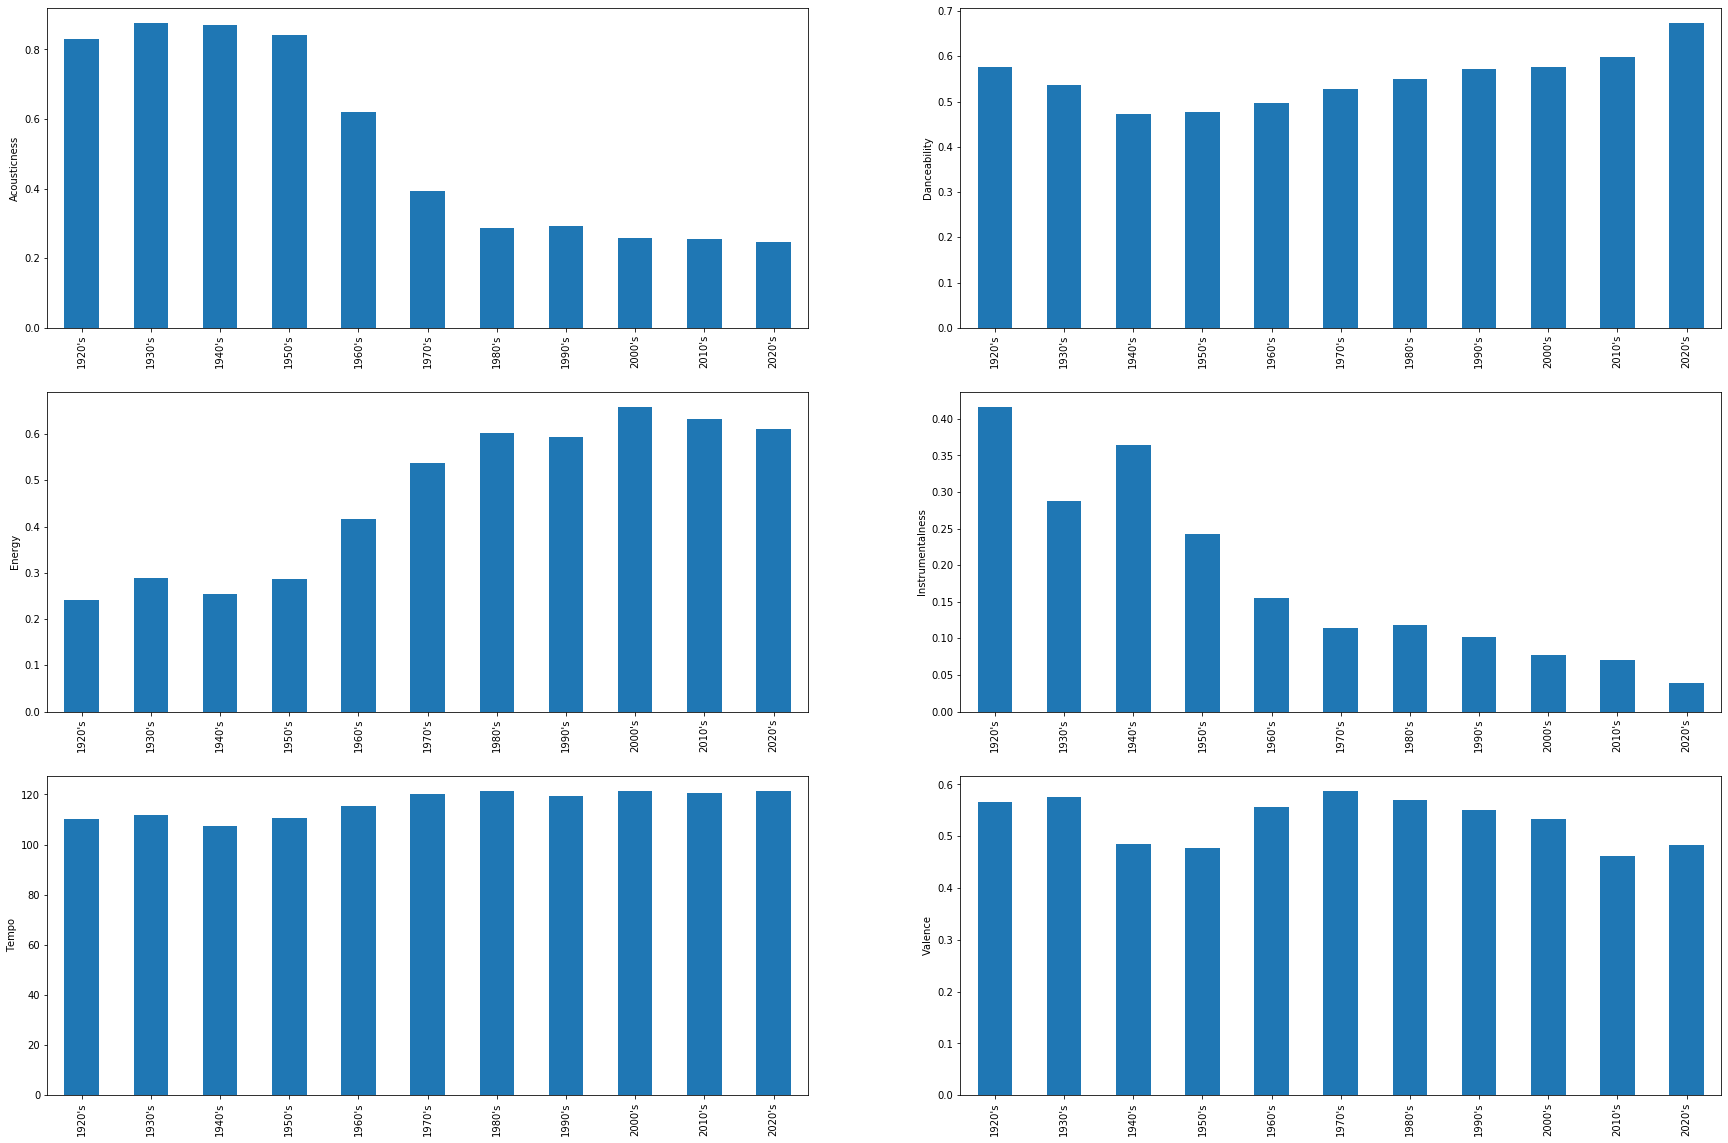

In [11]:
sp1, elements = plt.subplots(3, 2)

main_df.groupby("decade")["acousticness"].mean().plot.bar(ax=elements[0][0], figsize=(30,20))
elements[0][0].set_xlabel("")
elements[0][0].set_ylabel("Acousticness")

main_df.groupby("decade")["danceability"].mean().plot.bar(ax=elements[0][1], figsize=(30,20))
elements[0][1].set_xlabel("")
elements[0][1].set_ylabel("Danceability")

main_df.groupby("decade")["energy"].mean().plot.bar(ax=elements[1][0], figsize=(30,20))
elements[1][0].set_xlabel("")
elements[1][0].set_ylabel("Energy")

main_df.groupby("decade")["instrumentalness"].mean().plot.bar(ax=elements[1][1], figsize=(30,20))
elements[1][1].set_xlabel("")
elements[1][1].set_ylabel("Instrumentalness")

main_df.groupby("decade")["tempo"].mean().plot.bar(ax=elements[2][0], figsize=(30,20))
elements[2][0].set_xlabel("")
elements[2][0].set_ylabel("Tempo")

main_df.groupby("decade")["valence"].mean().plot.bar(ax=elements[2][1], figsize=(30,20))
elements[2][1].set_xlabel("")
elements[2][1].set_ylabel("Valence")

## EDA #2: The divide between explicit and non-explicit songs through the years.

Text(0.5, 1.0, 'Bar plot of explicit vs. non-explicit songs on Spotify through the years.')

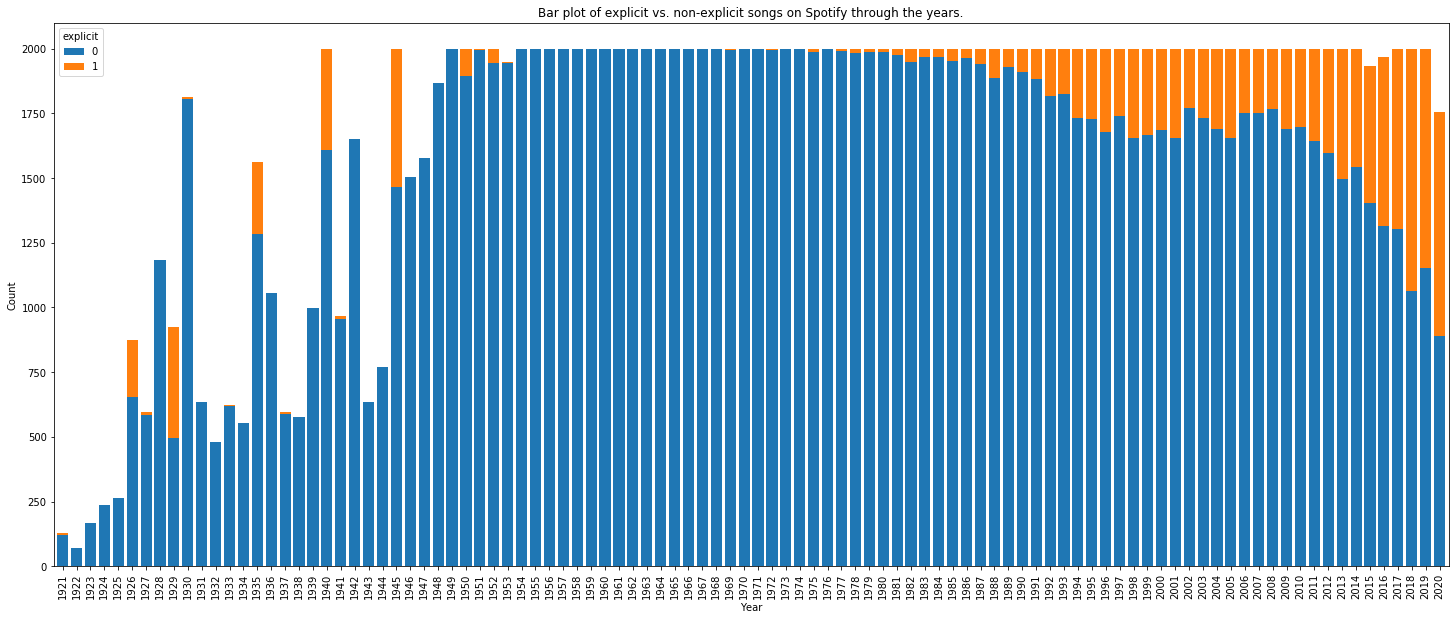

In [12]:
main_df.groupby(["year", "explicit"]).size().unstack().plot(kind="bar", stacked="True", figsize=(25,10), width=0.8)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Bar plot of explicit vs. non-explicit songs on Spotify through the years.")

## EDA #3: The top 10 genres for each musical element.
(acousticness, danceability, energy, instrumentalness, tempo, valence)